# A Study in Cigarettes
##### Cigarette sales and cross-sales analysis

#### Contents
##### 1. Business Problem
##### 2. Data Description
##### 3. Data Cleaning
##### 4. Exploratory Analysis
##### 5. Cigarette Portfolio Structure and Stocking Considerations
##### 6. Limitations
##### 7. Final Conclusion & Business Implications

## 1. Business Problem

My parents have been operating a neighbourhood convenience store since March 2025, retailing snacks, beverages, and other fast-moving consumer goods, including cigarettes. The presence of multiple nearby convenience stores selling highly substitutable products creates an intensely competitive environment, **forcing the business to operate on razor-thin margins**. In such a setting, small pricing or inventory mistakes can have a disproportionate impact on profitability and cash flow.

As first-time operators in this sector, my parents face structural challenges in identifying competitive price points, negotiating alternative suppliers, and managing inventory efficiently. In the short run, **cost reduction opportunities are limited**. Consequently, improving performance must come from **better capital allocation and demand-driven stocking decisions** — specifically, reducing unnecessary capital lock-up, avoiding stock-outs, and reallocating inventory towards products that generate the greatest commercial value.

**Cigarettes quickly emerged as a focal point** of this problem. They require **substantial upfront capital**, operate on **very thin margins**, and are a frequent source of customer complaints regarding price competitiveness. At face value, this makes cigarettes appear to be poor contributors to profitability. However, cigarettes are also a high-frequency purchase and **may play a strategic role in driving store traffic and cross-category sales**.

This project therefore investigates the **true commercial role of cigarettes** within the store. Rather than evaluating cigarettes solely on direct margins, the analysis examines whether cigarette sales function as a traffic-generating product that stimulates cross-purchases, and whether competitive cigarette pricing can indirectly improve overall store performance. The ultimate objective is to **inform restocking and pricing decisions** by identifying which cigarette products justify capital allocation and how cigarette inventory should be integrated into a broader retail strategy.

**Business Question:**
Should cigarettes be stocked and priced primarily as profit items or as traffic-driving products, and how should this affect restocking priorities and capital allocation?

## 2. Data Description

### 2a. Data Source
The dataset consists of transactional sales records from my parents' convenience store for each month from March 2025 to December 2025. Each record corresponds to a single product sold within a transaction, including its quantity, revenue, product name, category, and, date and time of sale. The data was extracted from the store’s point-of-sale (POS) system and does not contain customer-specifc details. 


### 2b. Structure and Granularity

The raw data is recorded at the item-transaction level, meaning each row represents one SKU sold in one transaction at a given timestamp. From this base table, multiple aggregated datasets were constructed:

* Monthly cigarette sales by SKU

* Monthly total cigarette volume and revenue

* Monthly cross-sale quantities and revenue

* Monthly category-level cross-sales

* Derived metrics such as average basket depth and average cross-sale revenue per cigarette

The primary unit of analysis throughout this project is monthly performance, chosen to smooth daily noise and highlight structural changes such as pricing adjustments and competitive shifts.

### 2c. Key Fields

    OrderDetDate – transaction date and time

    OrderHdrId - unique identifier for each transaction
    
    ItemName – product name

    ItemNo - unique identifier for each product
    
    Category – product category
    
    Quantity – units sold
    
    Amount – revenue generated (SGD)

    IsVoided - flags if the transaction was voided (Yes/No)

### 2d. Scope and Limitations

Several limitations should be noted:

The dataset covers a single small retail outlet, limiting external generalisability.

Customer identities are unavailable, preventing direct analysis of repeat behaviour or individual-level baskets.

Observed cross-sales are inferred from co-purchases within the same transaction and cannot fully establish causality.

The study period coincides with market changes, including competitor exit and entry and internal price adjustments, which may confound demand patterns.

Despite these constraints, the data is well-suited to answering the central business question: how cigarettes influence store traffic, basket composition, and capital allocation decisions.

## 3. Data Cleaning

### 3a. Importing relevant libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### 3b. Consolidating all the months into one table
For ease of data manipulation, the different month CSVs will be combined into a single Pandas Dataframe `df_mar_dec_25`.

In [4]:
names = ["mar25.csv", "apr25.csv", "may25.csv", "jun25.csv", "jul25.csv", "aug25.csv", "sep25.csv", "oct25.csv", "nov25.csv", "dec25.csv"]

df_mar_dec_25 = pd.concat(pd.read_csv("data/"+ i) for i in names)

### 3c. Removing voided transactions

In [5]:
df_mar_dec_25 = df_mar_dec_25[df_mar_dec_25["IsVoided"]=="No"]

### 3d. Formatting datetime
A new column `date` was created to house the datetime in a `pd.datetime` format for cleaner data processing.
January and February months (1 and 2) were removed from the dataset for consistency. `["Department", "Disc", "Remark", "Remark1"]` columns were removed from the dataset as they are not required in this study.

In [6]:
df_mar_dec_25["date"] = pd.to_datetime(df_mar_dec_25["OrderDetDate"], format="%Y/%m/%d %I:%M:%S %p")

df_mar_dec_25 = df_mar_dec_25[~df_mar_dec_25["date"].dt.month.isin([1, 2])]

df_mar_dec_25.drop(columns = ["Department", "Disc", "Remark", "Remark1"], inplace=True)

In [7]:
df_mar_dec_25.head(5)

,OrderDetDate,OrderHdrId,Category,ItemNo,ItemName,Quantity,UnitPrice,Amount,IsVoided,date
0,2025/03/28 6:56:42 PM,OR25032800480140,Al-Beer,I0010086,Corona Extra 355ml,2.0,4.7,9.4,No,2025-03-28 18:56:42
1,2025/03/21 7:20:17 PM,OR25032100480079,Al-Beer,I0010090,Hoegaarden 33Cl,3.0,3.9,11.7,No,2025-03-21 19:20:17
2,2025/03/13 10:07:08 PM,OR25031300480114,Al-Beer,I0010090,Hoegaarden 33Cl,2.0,3.9,7.8,No,2025-03-13 22:07:08
3,2025/03/22 7:33:49 PM,OR25032200480109,Al-Beer,I0010094,San Miguel Light 330ml,3.0,3.8,11.4,No,2025-03-22 19:33:49
4,2025/03/23 4:02:50 PM,OR25032300480029,Al-Beer,I0010094,San Miguel Light 330ml,3.0,3.8,11.4,No,2025-03-23 16:02:50


## 4. Exploratory Analysis

### 4a. The capital lock-up problem

Cigarettes consistently account for roughly **20% of monthly revenue** while contributing **less than 5% of total item volume**. This indicates that cigarettes are high-ticket but low-turnover products. According to my parents, per-pack margins range only between `$0.50 and $1.50`, implying that cigarettes generate substantial revenue but relatively limited gross profit. Because cigarettes are also expensive to procure, they lock up a disproportionate amount of working capital, constraining the store’s ability to invest in higher-margin products. 

On a standalone basis, this makes cigarettes appear unattractive to stock heavily.

In [8]:
month_agg = df_mar_dec_25.groupby(df_mar_dec_25["date"].dt.month)[["Quantity", "Amount"]].sum()
cigs_only = df_mar_dec_25[df_mar_dec_25["Category"]=="Smoke-Cigarette"]
cigs_agg = cigs_only.groupby(cigs_only["date"].dt.month)[["Quantity", "Amount"]].sum()

agg = month_agg.merge(cigs_agg, how = "inner", on = "date", suffixes = ["_total", "_cigs"])

# Calculate cigarette share in volume and revenue (%)
agg["cigs_share_vol"] = agg["Quantity_cigs"] * 100 /agg["Quantity_total"] 
agg["cigs_share_rev"] = agg["Amount_cigs"] * 100 /agg["Amount_total"]

In [9]:
plot_df = agg.copy()

plot_df["Quantity_non_cigs"] = plot_df["Quantity_total"] - plot_df["Quantity_cigs"]
plot_df["Amount_non_cigs"] = plot_df["Amount_total"] - plot_df["Amount_cigs"]

months = plot_df.index

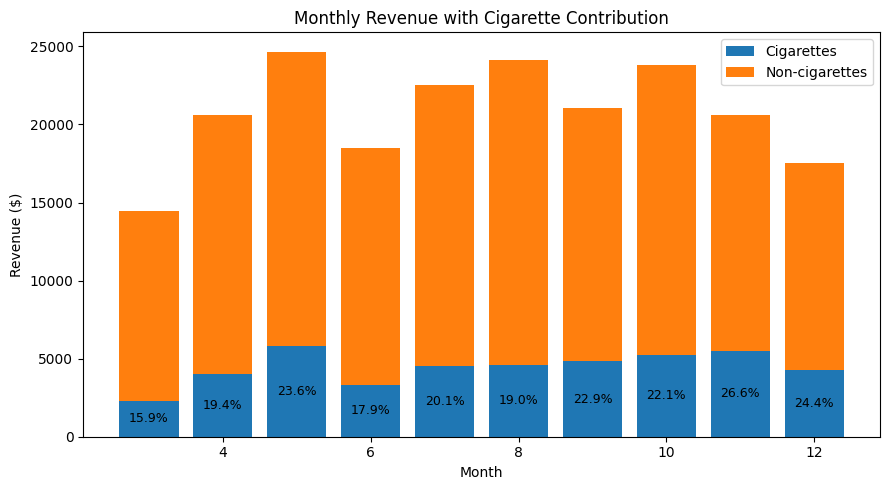

In [10]:
plt.figure(figsize=(9,5))

plt.bar(months, plot_df["Amount_cigs"], label="Cigarettes")
plt.bar(months, plot_df["Amount_non_cigs"],
        bottom=plot_df["Amount_cigs"],
        label="Non-cigarettes")

plt.title("Monthly Revenue with Cigarette Contribution")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.legend()

# percentage labels on cigarette segment
for i, pct in enumerate(plot_df["cigs_share_rev"]):
    plt.text(months[i],
             plot_df["Amount_cigs"].iloc[i]/2,
             f"{pct:.1f}%",
             ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()


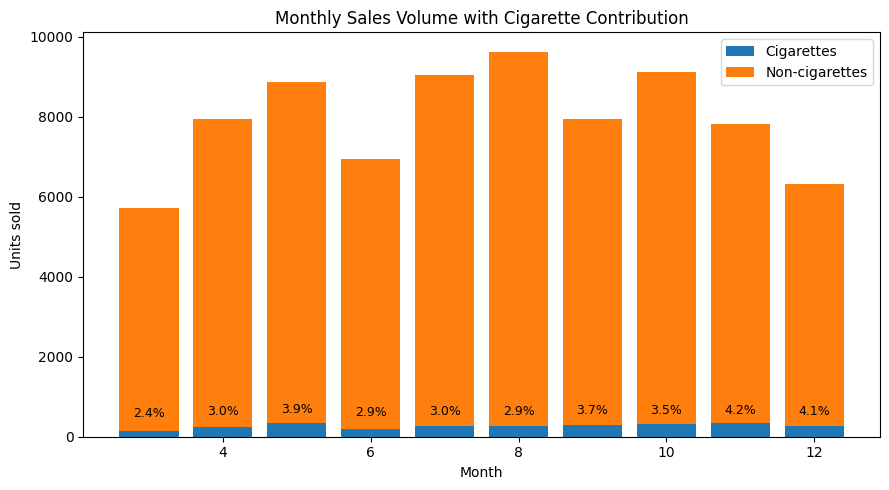

In [11]:
plt.figure(figsize=(9,5))

plt.bar(months, plot_df["Quantity_cigs"], label="Cigarettes")
plt.bar(months, plot_df["Quantity_non_cigs"],
        bottom=plot_df["Quantity_cigs"],
        label="Non-cigarettes")

plt.title("Monthly Sales Volume with Cigarette Contribution")
plt.xlabel("Month")
plt.ylabel("Units sold")
plt.legend()

for i, pct in enumerate(plot_df["cigs_share_vol"]):
    plt.text(months[i],
             plot_df["Quantity_cigs"].iloc[i]/2 + 500,
             f"{pct:.1f}%",
             ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()


###  4b. Do cigarettes generate indirect value?


However, evaluating cigarettes purely on direct margins ignores a potentially important role: cigarettes may function as traffic drivers that lead to the purchase of other, higher-margin items. This motivates an examination of cross-purchasing behaviour. 

The following bar chart shows the monthly proportion of cigarette packs sold in transactions that included other items (“cross-sale cigarettes”) versus those sold alone, from March to December 2025.

In [12]:
cigs_orders = cigs_only["OrderHdrId"].unique()

cigs_basket_orders = df_mar_dec_25[(df_mar_dec_25["OrderHdrId"].isin(cigs_orders)) 
    & (df_mar_dec_25["Category"]!="Smoke-Cigarette")]["OrderHdrId"].unique()

cigs_basket = cigs_only[cigs_only["OrderHdrId"].isin(cigs_basket_orders)]

cigs_basket_agg = cigs_basket.groupby(cigs_basket["date"].dt.month)[["Quantity"]].sum()

cigs_basket_vs_total = cigs_basket_agg.merge(cigs_agg[["Quantity"]], how="inner", on = ["date"], suffixes = ["_basket", "_total"])
cigs_basket_vs_total["basket_share_volume"] = cigs_basket_vs_total["Quantity_basket"] * 100/cigs_basket_vs_total["Quantity_total"]

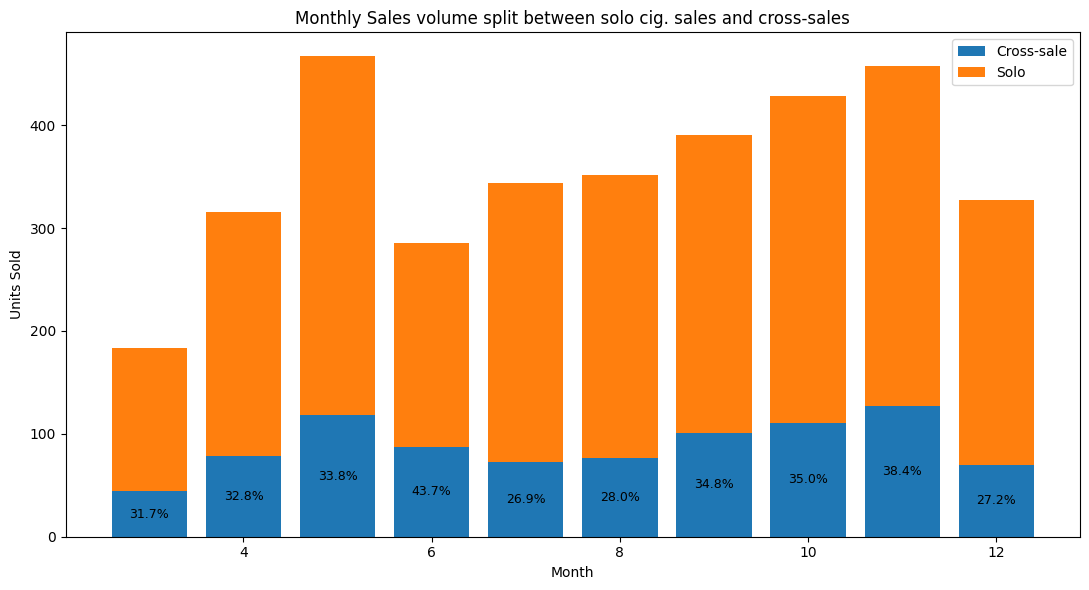

In [13]:
plot_df = cigs_basket_vs_total.copy()

plt.figure(figsize=(11,6))

plt.bar(plot_df.index, plot_df["Quantity_basket"], label="Cross-sale")
plt.bar(months, plot_df["Quantity_total"],
        bottom=plot_df["Quantity_basket"],
        label="Solo")

plt.title("Monthly Sales volume split between solo cig. sales and cross-sales")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend()

# percentage labels on cigarette segment
for i, pct in enumerate(plot_df["basket_share_volume"]):
    plt.text(months[i],
             plot_df["Quantity_basket"].iloc[i]/2,
             f"{pct:.1f}%",
             ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()

On average, **33.23% of cigarette packs sold generated at least one additional item purchase**. Moreover, from July to November, both the total quantity of cigarettes sold and the share of cross-sale cigarettes rose steadily. This indicates that growth in cigarette volume was not driven solely by thin, cigarette-only transactions, but was increasingly accompanied by broader baskets.

To evaluate whether rising cigarette sales translated into broader commercial value, we constructed **two conditional basket metrics**: 
* (1) average cross-sale revenue per cigarette
* (2) average cross-sale item depth per cigarette

These measure how much non-cigarette value and volume each cigarette unit brings into the store.

In [16]:
cigs_basket_items = df_mar_dec_25[df_mar_dec_25["OrderHdrId"].isin(cigs_basket_orders) & (df_mar_dec_25["Category"]!="Smoke-Cigarette")]
cross_rev = cigs_basket_items.groupby(cigs_basket_items["date"].dt.month)[["Quantity", "Amount"]].sum()


cross_per_cig = cross_rev.merge(cigs_agg, how="inner", on = "date", suffixes = ["_cross", "_cigs"])
cross_per_cig["avg_rev_per_cig"] = cross_per_cig["Amount_cross"]/cross_per_cig["Quantity_cigs"]
cross_per_cig["avg_depth_per_cig"] = cross_per_cig["Quantity_cross"]/cross_per_cig["Quantity_cigs"]



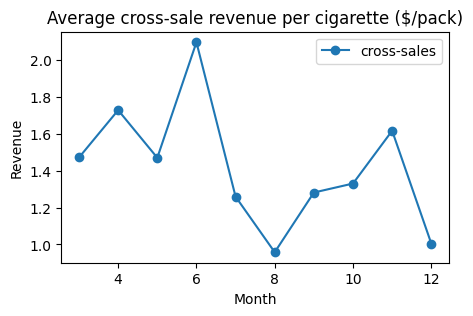

In [17]:
plt.figure(figsize=(5,3))

plt.plot(cross_per_cig.index, cross_per_cig["avg_rev_per_cig"], marker="o", label="cross-sales")


plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Average cross-sale revenue per cigarette ($/pack)")
plt.legend()
plt.show()

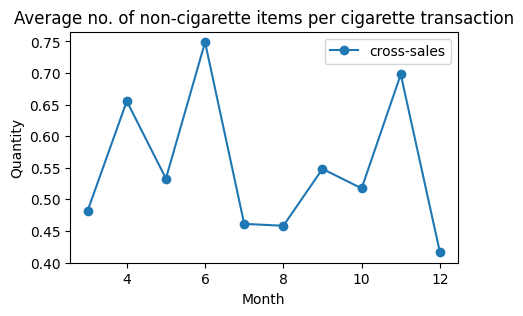

In [18]:
plt.figure(figsize=(5,3))

plt.plot(cross_per_cig.index, cross_per_cig["avg_depth_per_cig"], marker="o", label="cross-sales")


plt.xlabel("Month")
plt.ylabel("Quantity")
plt.title("Average no. of non-cigarette items per cigarette transaction")
plt.legend()
plt.show()

Both metrics peaked in June, when cigarette volume was relatively low, indicating that early demand was dominated by regular customers with richer baskets.

In July 2025, cigarette prices were reduced in response to competitive pressure from nearby stores, resulting in a noticeable increase in cigarette sales volume in subsequent months. This provided an opportunity to observe how cigarette-led traffic and purchasing behaviour evolved under changing market conditions.

Following this price adjustment, cigarette volume increased sharply, while both basket value and basket depth deteriorated, reaching a trough in August. This suggests that the initial growth phase was driven largely by thin, cigarette-only transactions.

However, from August to November, both cross-sale value and depth recovered steadily alongside continued growth in cigarette volume. This indicates that cigarette-driven traffic did not permanently dilute basket quality. Instead, broader purchasing behaviour progressively re-established itself as the customer base adjusted.

Overall, the results suggest that while aggressive cigarette pricing initially attracted lower-value traffic, cigarette sales eventually became associated with increasingly richer baskets. This supports the view of cigarettes as a traffic anchor that can contribute to wider store revenue, rather than a purely low-margin standalone product.

### 4c. Composition of items in cigarette anchored baskets

To understand the quality of these cross-sales, we analysed the composition of items purchased alongside cigarettes. The cross-sale baskets were dominated by beverages — particularly beer and carbonated beverages — alongside a sizeable contribution from small snacks and convenience items ("Others"). Notably, beer, carbonated beverages and "Others" consistently accounted for a large share of cigarette-linked purchases across months.

These categories typically carry substantially higher margins than cigarettes and require significantly lower upfront capital per unit. This suggests that cigarettes act as entry products that channel customers towards more profitable goods, strengthening the case that their business value lies not in cigarette margins themselves, but in the downstream purchases they stimulate.

**Note: "Others" is a distinct category in the POS containing small snacks and miscellaneous items, hence "Everything else" has been used to group items other than the top 5.**

In [20]:
cigs_basket_comp = cigs_basket_items.groupby(cigs_basket_items["Category"])[["Quantity"]].sum()
cigs_basket_comp = cigs_basket_comp.sort_values("Quantity", ascending=False)


# Split top 5 and the rest
top5 = cigs_basket_comp.head(5).reset_index(drop=False)
other = cigs_basket_comp.iloc[5:]["Quantity"].sum()

# Create final dataframe for pie chart
pie_df = top5.copy()
pie_df = pd.concat(
    [
        top5,
        pd.DataFrame({"Category": ["Everything Else"], "Quantity": [other]})
    ],
    ignore_index=True
)

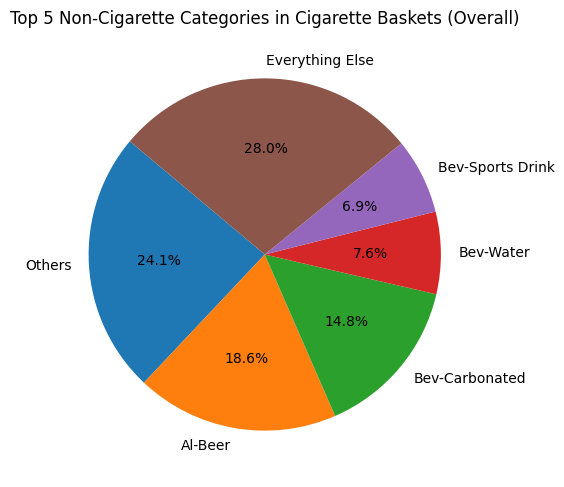

In [21]:
plt.figure(figsize=(5, 5))
plt.pie(
    pie_df["Quantity"],
    labels=pie_df["Category"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Top 5 Non-Cigarette Categories in Cigarette Baskets (Overall)")
plt.axis("equal")  # keeps it circular
plt.subplots_adjust(top=1.0)
plt.show()

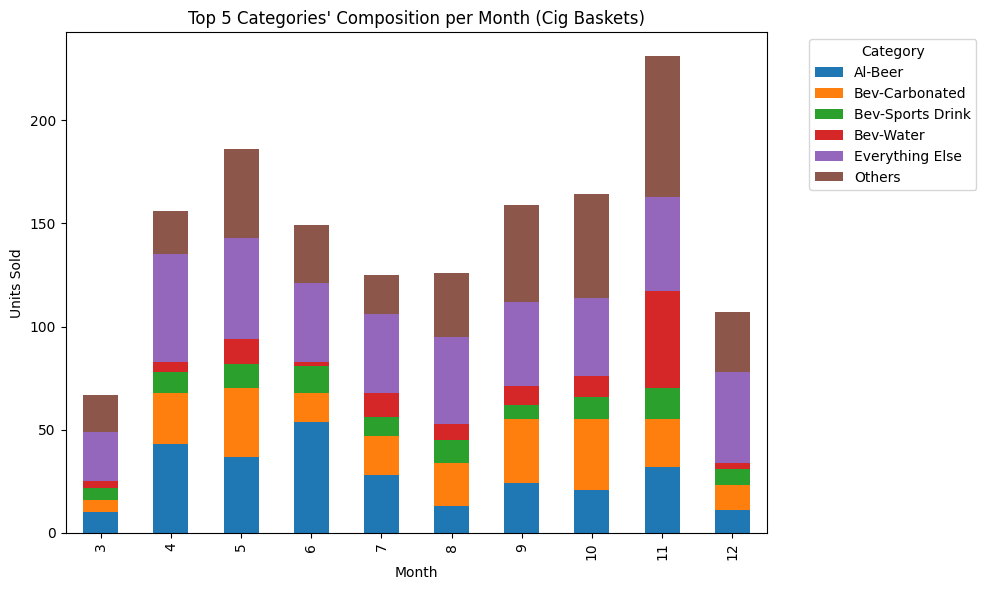

In [22]:
# Composition of the overall top 5 categories across the months

stack_df = (
    cigs_basket_items
    .groupby([cigs_basket_items["date"].dt.month, "Category"])["Quantity"]
    .sum()
    .reset_index()
)

top5_cats = (
    stack_df.groupby("Category")["Quantity"]
    .sum()
    .nlargest(5)
    .index
)

stack_df["Category"] = stack_df["Category"].where(
    stack_df["Category"].isin(top5_cats),
    "Everything Else"
)

stack_df = (
    stack_df
    .groupby(["date", "Category"])["Quantity"]
    .sum()
    .unstack(fill_value=0)
)

stack_df.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Top 5 Categories' Composition per Month (Cig Baskets)")
plt.ylabel("Units Sold")
plt.xlabel("Month")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


## 5. Cigarette Portfolio Structure and Stocking Considerations 

The presence and persistence of cross-sales from cigarettes gives confidence for investing in them. As mentioned earlier, although cigarettes themselves are not profitable, they are traffic-drivers, which in turn generate cross-sales from other high-margin goods. We gain further value in studying which cigarette products consistently generate more cross-sales than others, as reducing stockouts in those items and their cross-sale counterparts, we sustain our cigarette baskets and improve our profit potential. 


### 5a. Distribution of cross-sales potential among cigarettes

To identify which cigarette products most consistently generate downstream purchases, we define **a "cross-ratio" as the proportion of units sold in transactions that also contained non-cigarette items**.

A naive ranking by cross-ratio places several very low-volume items at the top. However, these are based on extremely small sample sizes (e.g., fewer than 10 packs over the entire period), making them statistically unstable and operationally unreliable.

To focus on commercially meaningful signals, we restrict attention to items with at least 50 units sold between March and December 2025.

Under this constraint, a smaller group of products stand out for combining both high sales volume and elevated cross-ratios, notably London Gold 20 Hp, Camel Menthol, Winston Classic Short and Viceroy Hokkaido Purple Boost. These products not only account for a large share of cigarette demand, but also consistently appear in transactions involving other store purchases.

In contrast, some high-volume products such as Marlboro Ice Blast 20Hp exhibit much lower cross-ratios, indicating that they are more often purchased in isolation. These items contribute less to indirect store revenue and should be evaluated primarily on their own stock-turn and margin dynamics.

This segmentation suggests that cigarettes are not homogeneous. A subset functions as traffic anchors that disproportionately stimulate broader baskets, while others behave more like standalone products. This distinction is important for inventory management: stock-outs of anchor products risk losing entire multi-item baskets, not just cigarette sales.

In [23]:
df_total = cigs_only.groupby(cigs_only["ItemName"])[["Quantity"]].sum()
df_basket = cigs_basket.groupby(cigs_basket["ItemName"])[["Quantity"]].sum()

cigs_ratio = df_total.merge(df_basket, how = "inner", on = "ItemName", suffixes = ["_total", "_cross"])
cigs_ratio["Cross_ratio"] = cigs_ratio["Quantity_cross"] / cigs_ratio["Quantity_total"]

cigs_ratio_filt = cigs_ratio[cigs_ratio["Quantity_total"] >= 50].copy()
cigs_ratio_filt.sort_values("Cross_ratio", inplace=True, ascending = False)

cigs_ratio_filt

,Quantity_total,Quantity_cross,Cross_ratio
ItemName,,,
London Gold 20 Hp,94.0,55.0,0.585106
Camel Menthol,76.0,33.0,0.434211
Viceroy hokkaido purple Boost,222.0,93.0,0.418919
Winston Classic Short,140.0,57.0,0.407143
Viceroy Hokkaido mint double melo boost,71.0,25.0,0.352113
winston blue Short,54.0,19.0,0.351852
Marlboro white menthol,99.0,34.0,0.343434
Marlboro Double Burst,91.0,31.0,0.340659
MARLBORO MENTHOL,147.0,50.0,0.340136


### 5b. Zooming in on London Gold 20 Hp

Among high-volume cigarettes, London Gold 20 Hp exhibits one of the highest cross-sale ratios (~59%). We therefore examine its associated baskets to understand the nature of this performance.

In [24]:
londongold_orders = df_mar_dec_25[(df_mar_dec_25["ItemName"]=="London Gold 20 Hp")]["OrderHdrId"].unique()
londong_basket_items = cigs_basket_items[cigs_basket_items["OrderHdrId"].isin(londongold_orders)]
londong_basket_items.groupby("ItemName")[["Quantity"]].sum().sort_values("Quantity", ascending = False)

,Quantity
ItemName,
kingfisher extra strong 500ml,56.0
Open Item,10.0
RedBull,3.0
Coca Cola 330ml,2.0
100 Plus 1.5L,1.0
Clean Brush,1.0
Kiyo grape juice,1.0
McDowel whisky,1.0
Peel Aloe Vera Juice,1.0


Observing all other items bought together with London Gold 20 Hp, we see that the Kingfisher Extra Strong 500ml beer not just tops the chart, it dominates all other items with a quantity of 56. This means that the beer is most likely the source of cross-sale for this cigarette product. To ascertain this hypothesis, we decided to look for similarities in the movement of both products across the months.

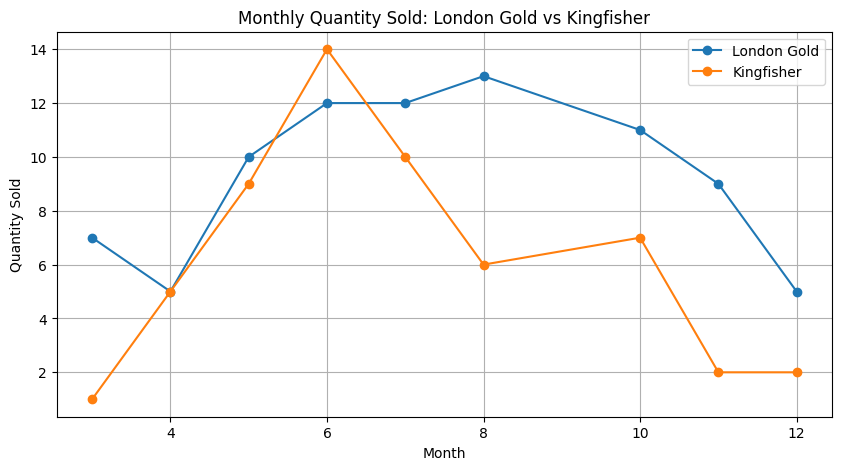

In [25]:
df_temp = londong_basket_items[londong_basket_items["ItemName"]=="kingfisher extra strong 500ml"]
df_king = df_temp.groupby(
    df_temp["date"].dt.month)[["Quantity", "Amount"]]

df_fil = cigs_only[cigs_only["OrderHdrId"].isin(londongold_orders)]
df_fil = df_fil.groupby(df_fil["date"].dt.month)[["Quantity", "Amount"]]

df_plot = (df_fil.sum()).merge(df_king.sum(), how = "inner", on="date", suffixes=("_londongold", "_kingfisher"))


plt.figure(figsize=(10, 5))

plt.plot(
    df_plot.index,
    df_plot["Quantity_londongold"],
    marker="o",
    label="London Gold"
)

plt.plot(
    df_plot.index,
    df_plot["Quantity_kingfisher"],
    marker="o",
    label="Kingfisher"
)

plt.xlabel("Month")
plt.ylabel("Quantity Sold")
plt.title("Monthly Quantity Sold: London Gold vs Kingfisher")
plt.legend()
plt.grid(True)

plt.show()


London Gold 20 Hp consistently co-moves with Kingfisher Extra Strong sales across months. At face value, this appears to indicate an alcohol-linked purchasing pattern rather than general convenience demand.

However, according to my parents, this pattern is driven primarily by a single habitual customer who repeatedly purchases this cigarette together with the same beer. This means the observed cross-sale is not market-wide, but highly concentrated.

As such, the business value of this product lies less in scalable cross-selling potential and more in protecting an existing high-value basket. At the same time, this basket is extremely fragile: if this customer leaves, both the cigarette sales and the associated beer co-movement may disappear.

Therefore, while London Gold 20 Hp should be kept in stock to avoid disrupting this recurring basket, it should be held at minimal levels. Increasing inventory is unlikely to increase sales, and carries a high risk of tying up cash without generating additional profit.

### 5c. From product-level signals to a portfolio structure

While individual products such as London Gold 20 Hp show high cross-sale ratios, the case analysis demonstrates that cross-ratios alone are insufficient to guide stocking decisions. High ratios derived from small volumes may reflect highly concentrated customer behaviour rather than scalable demand.

To support inventory decisions, cigarette products were therefore evaluated jointly on:

* Demand scale (total units sold)

* Cross-sale intensity (cross-ratio)

This allows cigarette products to be interpreted not only by how often they appear in baskets, but also by how reliably and operationally meaningful those patterns are.

Using this framework, cigarette products can be grouped into four functional roles:

* Core traffic anchors (high volume, low cross-ratio): reliably generate footfall but tend to be purchased alone.

* Scalable basket drivers (high volume, moderate–high cross-ratio): reliably generate both traffic and cross-sales.

* Fragile basket protectors (low volume, high cross-ratio): associated with valuable but highly concentrated baskets.

* Low-impact products (low volume, low cross-ratio): weak traffic and weak basket contribution.

This portfolio view allows stocking depth to be aligned with business role rather than raw revenue.

Products with fewer than 50 units sold over the period were excluded from the portfolio mapping, as cross-ratios derived from sparse transactions are unstable and may reflect highly concentrated behaviour rather than generalisable demand.

The remaining products (≥50 units) were then evaluated jointly on demand scale (total units sold) and cross-sale intensity (cross-ratio). A cross-ratio reference level of 0.40 was used to distinguish above-average basket contribution, while demand scale was segmented relative to the median of the ≥50-unit group.

This yields a four-quadrant portfolio structure aligning cigarette products with distinct business roles.

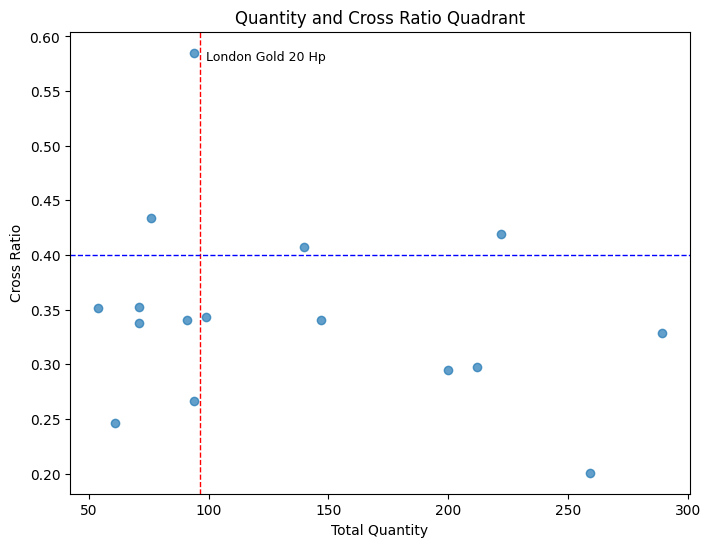

In [26]:
plt.figure(figsize=(8, 6))

plt.scatter(
    cigs_ratio_filt["Quantity_total"],
    cigs_ratio_filt["Cross_ratio"],
    alpha=0.7
)

plt.axvline(x=cigs_ratio_filt["Quantity_total"].median(), color="red", linestyle="--", linewidth=1)
plt.axhline(y=0.40, color="blue", linestyle="--", linewidth=1)

to_label = cigs_ratio_filt[cigs_ratio_filt.index == "London Gold 20 Hp"]

for _, row in to_label.iterrows():
    plt.text(
        row["Quantity_total"] + 5,
        row["Cross_ratio"] - 0.01,
        "London Gold 20 Hp",
        fontsize=9,
        ha="left",
        va="bottom",
    )

plt.xlabel("Total Quantity")
plt.ylabel("Cross Ratio")
plt.title("Quantity and Cross Ratio Quadrant")

plt.show()


In [27]:
cigs_ratio_filt["cross_label"] = pd.cut(
    cigs_ratio_filt["Cross_ratio"],
    bins=[-float("inf"), 0.4, float("inf")],
    labels=["A", "B"]
)

cigs_ratio_filt["qty_label"] = pd.cut(
    cigs_ratio_filt["Quantity_total"],
    bins=[-float("inf"), cigs_ratio_filt["Quantity_total"].median(), float("inf")],
    labels=["A", "B"]
)

cigs_ratio_filt["combo"] = (
    cigs_ratio_filt["qty_label"].astype(str)
    + cigs_ratio_filt["cross_label"].astype(str)
)

category_map = {
    "BA": "Core traffic anchors",
    "BB": "Scalable basket drivers",
    "AB": "Fragile basket protectors",
    "AA": "Low-impact products",
}

category_order = [
    "Core traffic anchors",
    "Scalable basket drivers",
    "Fragile basket protectors",
    "Low-impact products",
]

cigs_ratio_filt["product_category"] = cigs_ratio_filt["combo"].map(category_map)

cigs_ratio_filt["product_category"] = pd.Categorical(
    cigs_ratio_filt["product_category"],
    categories=category_order,
    ordered=True
)

cigs_ratio_filt = cigs_ratio_filt.sort_values("product_category")

cigs_ratio_filt[["Quantity_total", "Cross_ratio", "product_category"]]

,Quantity_total,Cross_ratio,product_category
ItemName,,,
Marlboro white menthol,99.0,0.343434,Core traffic anchors
MARLBORO MENTHOL,147.0,0.340136,Core traffic anchors
MARLBORO GOLD,289.0,0.328720,Core traffic anchors
MARLBORO RED,212.0,0.297170,Core traffic anchors
Viceroy hokkaido mint Blue boost,200.0,0.295000,Core traffic anchors
Marlboro Ice Blast 20Hp,259.0,0.200772,Core traffic anchors
Viceroy hokkaido purple Boost,222.0,0.418919,Scalable basket drivers
Winston Classic Short,140.0,0.407143,Scalable basket drivers
London Gold 20 Hp,94.0,0.585106,Fragile basket protectors


### 5d. Stocking implications by quadrant

**1. Core traffic anchors:**
* Reliable demand drivers but poor profiters.

These products should primarily be stocked to avoid stockouts and protect customer traffic, rather than to stimulate additional purchases.

Stocking Implications:
* Maintain high availability with conservative safety stock
* Accept shallow margins as the cost of sustaining traffic
* Avoid excessive depth beyond demand needs (capital lock-up risk)
* Optimise mainly for service level, not basket expansion

**2. Scalable basket drivers:**
* Most valuable, brings both traffic and baskets.

These are the cigarettes most worth protecting and supporting, as each stockout risks losing both the cigarette sale and multiple downstream 
purchases.

Stocking Implications:
* Prioritise both availability and depth
* Actively coordinate with cross-sale counterparts (beer, carbonated drinks, snacks)

**3. Fragile basket protectors:**
* High basket association but very small consumer base.

These products should be stocked defensively rather than aggressively.

Stocking Implications:
* Keep minimal but continuous stock
* Focus on avoiding stockouts, not expanding depth
* Monitor individually rather than statistically
* Avoid bulk buying

**4. Low-impact products:**
* Weak traffic, weak basket

These products contribute little to either traffic or basket value and should not command scarce working capital.

Stocking Implications:
* Buy in small, infrequent batches
* Lowest priority for cash allocation
  

## 6. Limitations

This study is exploratory and subject to several limitations.

First, the analysis does not incorporate product-level cost or profit data. As a result, indirect commercial value is inferred through cross-sale volume and revenue rather than true contribution margins. This prevents precise estimation of the incremental profit generated by cigarette-driven baskets.

Second, observed cross-sales reflect transactional correlation rather than causal impact. While rising cigarette volumes coincided with changes in basket composition, this does not prove that cigarettes caused additional purchases. Some cross-sales may reflect stable customer habits rather than cigarette-induced demand.

Third, the dataset does not capture stockout events or unmet demand. Without visibility on availability constraints, it is not possible to estimate lost sales or to derive optimal inventory levels.

Fourth, the analysis is based on a limited time window and a single-store setting. Several product-level relationships appear driven by a small number of habitual customers, reducing the generalisability of some product-level signals.

Finally, while this study develops a portfolio framework for cigarette products, it does not implement a formal demand forecasting or inventory optimisation model. As such, recommendations remain directional rather than prescriptive.

## 7. Final Conclusion & Business Implications

This study began with a practical retail concern: cigarettes tie up a large amount of capital, operate on thin margins, and were perceived by customers as uncompetitively priced. This raised the question of whether cigarette inventory should be reduced and capital redeployed elsewhere, or whether cigarettes play a deeper strategic role in store performance.

Our analysis shows that cigarettes should not be evaluated as a standalone profit product. While direct margins are low, cigarette purchases frequently generate cross-sales across beverages, alcohol and convenience categories. On average, a substantial share of cigarette transactions include additional items, confirming that cigarettes function as a traffic-driving product.

Following price adjustments, cigarette volume increased significantly. Although early growth was accompanied by a temporary deterioration in basket depth — indicating an influx of thin, cigarette-only transactions — cross-sales recovered steadily in subsequent months. From August to November, rising cigarette volume coincided with increasing cross-sale quantities and stabilising basket depth. This suggests that cigarette-driven traffic does not permanently dilute basket quality, and that low-margin cigarette sales can translate into broader commercial value.

Product-level analysis further indicates that cross-sale impact is not evenly distributed across cigarette products. While tiering structures were unstable over time, a small number of cigarette products consistently acted as anchors, while many others showed weak or inconsistent cross-sale linkage. This implies that capital efficiency can be improved not by reducing cigarette exposure wholesale, but by prioritising high-impact cigarette products and rationalising long-tail variants.

Taken together, these findings suggest that cigarettes should be treated as strategic traffic generators rather than pure profit drivers. A competitive cigarette pricing strategy can be commercially viable if paired with deliberate cross-category optimisation. In practical terms, this implies maintaining strong availability of high-impact cigarette products, while co-optimising inventory and merchandising of responsive cross-sale categories such as beverages and alcohol.

While this study does not yet yield a precise optimal stock quantity, it establishes the analytical foundation for a cigarette-led demand strategy. Future work incorporating product-level stockouts, transaction-level baskets, and demand forecasting would allow the development of a more rigorous restocking and capital allocation model.

## _Credits:_
I am grateful to my parents for the opportunity to access transactional data from their store's POS, and apply essential skills I have developed in my study of data science and analytics. 